# Lecture 3-4 Hands-on Session on Convolutional Networks


- Authors : Eis Annavini, Alessio Ansuini
- References : Neural Networks and Deep Learning, by Michael Nielsen

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
from keras.datasets import mnist
from keras import layers
from keras.models import Model, load_model
from keras import optimizers
from keras import losses
from keras import callbacks
from keras.utils.np_utils import to_categorical
from keras import regularizers
import os.path as path
import os
import pickle
from keras import backend as K
from tqdm import tnrange
from helpers import show_test

jtplot.style(grid=False, ticks=True)

Using TensorFlow backend.


In [2]:
#help(mnist.load_data)

(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_train, l_test = to_categorical(l_train), to_categorical(l_test)
i_validate = i_train[50000:, :, :, :]
i_train = i_train[0:50000, :, :, :]
l_validate = l_train[50000:, :]
l_train = l_train[0:50000, :]

In [3]:
minibatch_size = 10
n_epochs = 60
learn_rate = 0.1
history = {}
tb_params = {
    'write_images': True, 'histogram_freq': 5, 
    'write_grads': True, 'write_graph': False
            }
activation_fcn = 'sigmoid'

In [4]:
def enhance_mnist(i_train, l_train, transf = [(1, 0), (-1, 0), (0, 1), (0, -1)]):
    i_enhanced = []
    l_enhanced = []
    for i in tnrange(i_train.shape[0]):
        img = i_train[i, :, :, :]
        label = l_train[i, :]
        i_enhanced.append(img)
        l_enhanced.append(label)
        for shift in transf:
            x = np.pad(img, ((abs(shift[0]), abs(shift[0])),
                         (abs(shift[1]), abs(shift[1])), (0, 0)), 'constant')
            x = np.roll(x, shift, (0, 1))
            x = x[abs(shift[0]):(x.shape[0]-abs(shift[0])),
                  abs(shift[1]):(x.shape[1]-abs(shift[1])), :]
            i_enhanced.append(x)
            l_enhanced.append(label)
    i_enhanced = np.array(i_enhanced)
    l_enhanced = np.array(l_enhanced)
    perm_idx = np.random.permutation(i_enhanced.shape[0])
    return i_enhanced[perm_idx, :, :, :], l_enhanced[perm_idx, :]

In [5]:
i_enh, l_enh = enhance_mnist(i_train, l_train)

In [6]:
activation_fcn = 'relu'
lmbd = 0.01
learn_rate = 0.03
minibatch_size = 100
minimum_lr = 1e-5

In [ ]:
regularization = None#regularizers.l2(lmbd)

models = []
img = layers.Input(shape=(28,28,1,))
for i in range(5):
    x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(10, activation='softmax')(x)
    models.append(Model(img, out))
opt = optimizers.SGD(lr=learn_rate)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=minimum_lr, verbose=True)
out_layers = [model.output for model in models]

for i in range(5):
    model = models[i]
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
    h = model.fit(
        i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
        batch_size=minibatch_size, callbacks=[reduce_lr]
        )
    model.save(path.join('models', "convolutional_voting_{}.h5".format(i)))

avg_layer = layers.Average()(out_layers)
avg_model = Model(img, avg_layer)
avg_model.save(path.join('models', "convolutional_voting_avg.h5"))

Train on 250000 samples, validate on 10000 samples
Epoch 1/60
250000/250000 [==============================] - 17s 70us/step - loss: 0.4537 - acc: 0.8498 - val_loss: 0.0626 - val_acc: 0.9819
Epoch 2/60
250000/250000 [==============================] - 15s 59us/step - loss: 0.1391 - acc: 0.9566 - val_loss: 0.0450 - val_acc: 0.9874
Epoch 3/60
250000/250000 [==============================] - 15s 60us/step - loss: 0.0995 - acc: 0.9690 - val_loss: 0.0430 - val_acc: 0.9863
Epoch 4/60
250000/250000 [==============================] - 15s 60us/step - loss: 0.0821 - acc: 0.9748 - val_loss: 0.0327 - val_acc: 0.9901
Epoch 5/60
250000/250000 [==============================] - 15s 60us/step - loss: 0.0714 - acc: 0.9775 - val_loss: 0.0307 - val_acc: 0.9910
Epoch 6/60
250000/250000 [==============================] - 15s 59us/step - loss: 0.0637 - acc: 0.9799 - val_loss: 0.0290 - val_acc: 0.9921
Epoch 7/60
250000/250000 [==============================] - 15s 59us/step - loss: 0.0585 - acc: 0.9817 - val_

250000/250000 [==============================] - 15s 60us/step - loss: 0.0226 - acc: 0.9928 - val_loss: 0.0198 - val_acc: 0.9949
Epoch 57/60
250000/250000 [==============================] - 15s 60us/step - loss: 0.0224 - acc: 0.9927 - val_loss: 0.0198 - val_acc: 0.9949
Epoch 58/60
250000/250000 [==============================] - 15s 60us/step - loss: 0.0226 - acc: 0.9926 - val_loss: 0.0198 - val_acc: 0.9949
Epoch 59/60
250000/250000 [==============================] - 15s 60us/step - loss: 0.0222 - acc: 0.9927 - val_loss: 0.0198 - val_acc: 0.9949
Epoch 60/60
250000/250000 [==============================] - 15s 59us/step - loss: 0.0219 - acc: 0.9931 - val_loss: 0.0198 - val_acc: 0.9949
Train on 250000 samples, validate on 10000 samples
Epoch 1/60
250000/250000 [==============================] - 15s 60us/step - loss: 2.3119 - acc: 0.1002 - val_loss: 2.2989 - val_acc: 0.1035
Epoch 2/60
250000/250000 [==============================] - 15s 60us/step - loss: 2.3105 - acc: 0.1013 - val_loss: 2

/home/eannavi/.local/envs/keras-tf/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


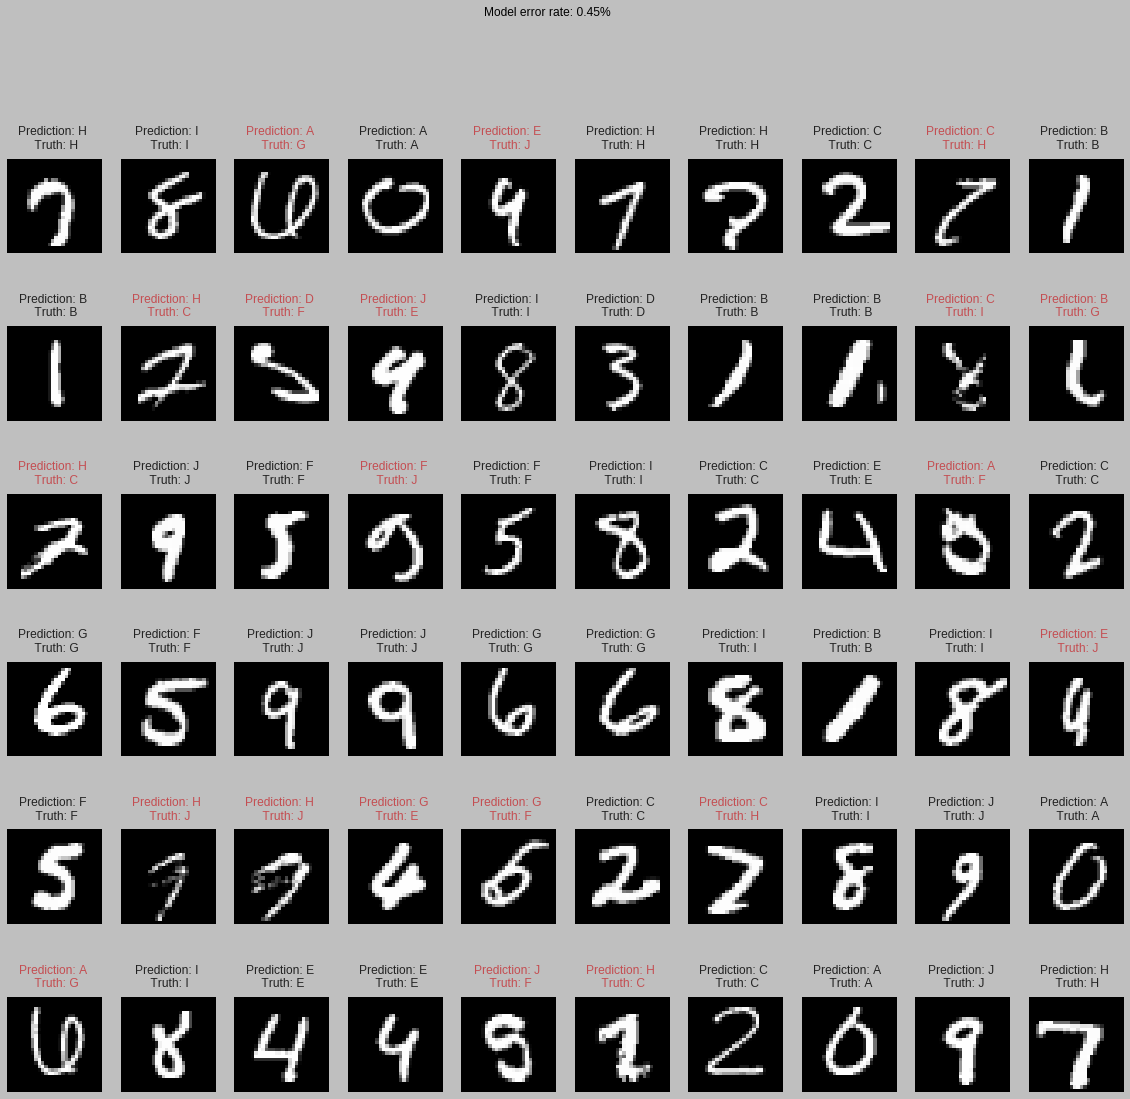

In [9]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_voting_avg.h5'))
K.set_learning_phase(0)
show_test(model, (i_test, l_test))